In [1]:
%matplotlib inline

flag_simulate = True
flag_death = True
flag_average = False
flag_plot = False
flag_plot_data = True

#flag_death = False outputs the infected
#flag_average = True computes the growth rate and growth factor averaging the last three days as long as data for these days is available
#flag_plot = True plot and export results
#flag_plot_data = True plot the data for countries

import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import csv

import datetime

import requests
import io

def res_values(values, flag_res):
    res = values
    if flag_res:
        values_dif = np.roll(values, -1) - np.roll(values, 1)
        res = np.roll(values_dif, 0)/np.roll(values_dif, 1)
    return res

def func_sig(X, *p, flag_res):
    if flag_res:
        c1,c2,c3 = p
        AB = np.exp(c1*c2)
        A = np.exp(c1)
        AX = np.exp(c1*X)
        model = (A*AB+AX) / (AB + A*AX)
    else:
        c1,c2,c3 = p
        model = c3*(1/(1 + np.exp(-(c1 * (-c2 + X)))))
    return model

def growth_rate(data, avg = False):
    Growthr=(data[-1]-data[-2])/data[-2]
    if avg:
        if (len(data)-5)>=5:
            le=3
            array=np.zeros([le])
        else:
            le=len(data)-2
            array=np.zeros([le])
                
        for i in (np.arange(le)+1):
            array[i-1] = (data[-i]-data[-(i+1)])/(data[-(i+2)])
        Growthr = np.absolute(np.mean(array))
    return Growthr


    
def growth_factor(data, avg = False):
    Growthf = (data[-1]-data[-2])/(data[-2]-data[-3])
    if avg:
        if (len(data)-5)>=5:
            le=3
            array=np.zeros([le])
        else:
            le=len(data)-2
            array=np.zeros([le])
                
        for i in (np.arange(le)+1):
            den = data[-(i+1)]-data[-(i+2)]
            if den!=0:
                array[i-1] = (data[-i]-data[-(i+1)])/(den)
            else:
                array[i-1] = den          
        Growthf = np.absolute(np.mean(array))
    return Growthf



def plot_results(param):
    data = param['data']
    post_pred = param['post_pred']
    countries = param['countries']
    ylabel = param['ylabel']
    flag_res = param['flag_res']
    xlim = param['xlim']
    ylim = param['ylim'] 
    log_flag = param['log_flag']
    figsize = param['figsize']
    trace = param['trace']
    method = param['method']

    n_countries = len(countries)
    fig = plt.figure(figsize=figsize)
    colors = plt.cm.rainbow(np.linspace(0, 1, n_countries))
    plttype = 'Sigmoid-simulation-'
    
    for i, country in enumerate(countries):
        if flag_res:
            plttype = 'Growth-'
            fig = plt.figure(figsize=figsize)
        delay = np.argmin(np.abs(data[country+'-death'] - 17))
        delay = 0
        plt.scatter(data[country+'-day'] - delay, res_values(data[country+'-death'], flag_res), color=colors[i]                    
                    , edgecolors='black', linewidth=0.3,
                    label = country+' confirmed data', zorder=200)
                    
        plt.scatter(data[country+'-day'][-1] - delay, res_values(data[country+'-death'][-1], flag_res), color=colors[i]
                    , edgecolors='white', linewidth=1
                    , label = country+' today',zorder=200, marker = '*', s = 100)
        plt.plot(np.arange(0, post_pred[country].shape[1]) - delay, res_values(post_pred[country], flag_res).T, alpha=0.2, color=colors[i])
        p = [np.max(trace['c1'][:,i]),np.max(trace['c2'][:,i]),np.max(trace['c3'][:,i])]
        #plt.plot(np.linspace(0,60-1,60) - delay, func_sig(np.linspace(0,60-1,60), *p, flag_res = flag_res), alpha=1, color=colors[i])

        plt.xlabel('# Days from countries first death report')
        plt.ylabel(ylabel)
        plt.title(method)
        
        cn = country
        if country == 'China':
            cn = 'Hubai'
            
        if cn in Dates.keys():
            for key, value in Dates[cn].items():
                ind = np.argwhere(data[country+'-date'] == key)[0][0]
                plt.plot([ind - delay,ind - delay],[0,30000], value[1], label = cn+'-'+ value[0], color=colors[i])

        plt.ylim(ylim)
        plt.xlim(xlim)
        
        if flag_res:
            lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), fancybox=True, shadow=True, ncol=6)
            plt.savefig('../images/'+method+plttype+country+'.png', dpi=90, bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.grid(alpha=0.2)

    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), fancybox=True, shadow=True, ncol=6)
    name = 'linear'
    
    if log_flag: 
        plt.yscale('log')
        name = 'log'
    if ~flag_res:    
        plt.savefig('../images/'+method+plttype+name+'.png', dpi=90, bbox_extra_artists=(lgd,), bbox_inches='tight')

def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    plt.style.use('dark_background')
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['color'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)
            plt.grid(alpha=0.2)
        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        
        legends.append(name)
        #if k_is_color:
        color=k_is_color[name]
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color='white'
        )
        
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            vertical=True,
            color='white'
        )
        sns.set_style("whitegrid", {'axes.grid' : False})
    plt.legend(legends)
    plt.savefig('../images/'+'parameters'+method+'-'+cn[0]+'-'+cn[1]+'.png', dpi=90)
   
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

if flag_death:
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
else:
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

df_data = pd.read_csv(url, error_bad_lines=False)


countries = ['China','Italy','Spain','Iran','France']
th = 2

In [2]:
data = {}
data_table = {}

for country in df_data['Country/Region'].unique():
    if country == 'Europe':
        select = ['Italy','Spain','Germany','France'] 
    else:
        select = [country]
    value = df_data[df_data['Country/Region'].isin(select)].drop(['Province/State','Country/Region','Lat','Long'], axis=1).sum(axis=0)
    value = value[value >= th] 
    data[country+'-death'] = value.values
    days = len(data[country+'-death'])
    data[country+'-day'] = np.linspace(0,days-1,days)
    data[country+'-date'] = value.index.values
    if len(data[country+'-death']) > 2:
        Growthr = growth_rate(data[country+'-death'],flag_average)
        Growthf = growth_factor(data[country+'-death'],flag_average)
        data_table[country] = [data[country+'-day'][-1],data[country+'-death'][-1],str(np.round(Growthr*100, decimals=2))+" %", np.round(Growthf, decimals=2)]

        
html_content = '<h3>Date of the last update: '+str(data['Spain'+'-date'][-1])+'</h3>'+pd.DataFrame.from_dict(data_table, orient='index', 
                       columns = ['# days', '# deaths',  'Growth Rate'
                        , 'Growth Factor']).sort_values(by=['# deaths'], ascending = False).to_html().replace('\n', '')
html_file = open("../tables/tabledata.html", "wt")
html_file.write(html_content)
html_file.close()


html_content = '<h3>The data and the simulations where update on: '+str(data['Spain'+'-date'][-1])+'</h3>' 
html_file = open("../tables/last_update.html", "wt")
html_file.write(html_content)
html_file.close()

Dates = {'Spain':{'3/8/20':['M8','-.'],'3/13/20':['Lockdown','--']},
'Italy':{'3/9/20':['Lockdown','--']},
'Hubai':{'1/23/20':['Lockdown','--']}}

n_countries = len(countries)

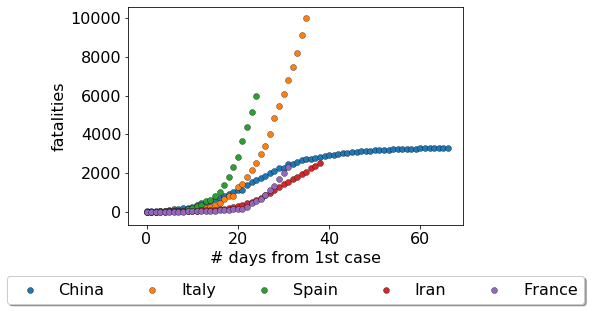

In [3]:
if flag_plot_data:
    if flag_death:
        ylab='fatalities'
    else:
        ylab='infected'
    
    legends=[]
    for country in countries:
        legends.append(country)
        plt.scatter(data[country+'-day'], data[country+'-death']
                    , edgecolors='black', linewidth=0.3,
                    label = country+' confirmed data', zorder=200)
    plt.legend(legends)
    plt.xlabel('# days from 1st case')
    plt.ylabel(ylab)
    plt.legend(legends,loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=6)

    
    plt.savefig('../images/'+'data_'+ylab+'.png', dpi=90, bbox_inches='tight')


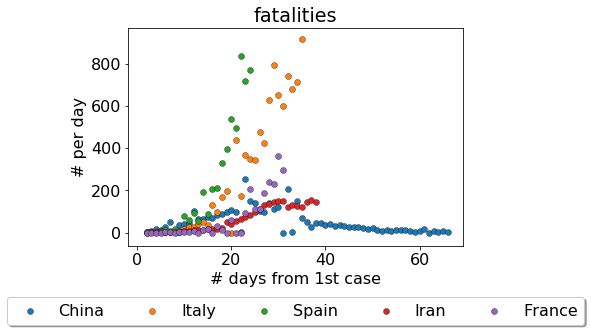

In [4]:
if flag_plot_data:
    
    legends=[]
    for country in countries:
        datam1=data[country+'-day'][1:]
        legends.append(country)
        Growthf = []
        datared = data[country+'-death']
        for i in range(len(datam1)-1):
            Growthf_local = (datared[(i+1)]-datared[(i)])
            Growthf.append(Growthf_local)
            
        plt.scatter(datam1[1:], Growthf
                    , edgecolors='black', linewidth=0.3,
                    label = country+' confirmed data', zorder=200)
    plt.legend(legends,loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=6)
    plt.xlabel('# days from 1st case')
    plt.ylabel('# per day')
    plt.title(ylab)
    plt.savefig('../images/'+'data_'+ylab+'per_day.png', dpi=90, bbox_inches='tight')

In [5]:

if flag_simulate:
    models = {}
    traces = {}
    marginal_likelihood = {}
    post_preds = {}
    for method in ['gompertz-model', 'log-model']:
        #hide
        with pm.Model() as model:
            ############
            # Intercept
            # Group mean
            clim = {}

            if method == 'log-model':
                clim['c1s'] = 1.5
                clim['c1M'] = 1.5

                clim['c2s'] = 15
                clim['c2M'] = 30

                clim['c3s'] = 20000
                clim['c3M'] = 10000

            if method == 'gompertz-model':
                clim['c1s'] = 1
                clim['c1M'] = 1

                clim['c2s'] = 60
                clim['c2M'] = 70

                clim['c3s'] = 8000
                clim['c3M'] = 20000
                
            const = {}
            for cn in ['c1','c2','c3']:
                grp = pm.Normal(cn+'grp', clim[cn+'M'], clim[cn+'s'])
                # Group variance
                grp_sigma = pm.HalfNormal(cn+'grp_sigma', clim[cn+'s'])
                # Individual intercepts
                const[cn] = pm.Normal(cn,  mu=grp, sigma=grp_sigma,  shape=n_countries)

            sigma = pm.HalfNormal('sigma', 10000., shape=n_countries)

            # Create likelihood for each country
            for i, country in enumerate(countries):
                print(country)
                # By using pm.Data we can change these values after sampling.
                # This allows us to extend x into the future so we can get
                # forecasts by sampling from the posterior predictive
                x = pm.Data(country + "-x",  data[country+'-day'])
                cases = pm.Data(country + "-y",  data[country+'-death'])

                # Likelihood
                if method == 'log-model':
                    pm.NegativeBinomial(
                        country, 
                        const['c3'][i]*(1/(1 + np.exp(-(const['c1'][i] * (-const['c2'][i] + x))))),
                        sigma[i], 
                        observed=cases)
                if method == 'gompertz-model':
                    pm.NegativeBinomial(
                        country, 
                        const['c3'][i]*np.exp(-np.exp(-const['c1'][i]*(x-const['c2'][i]))),
                        sigma[i], 
                        observed=cases)   
                    
            models[method] = model

            traces[method] = pm.sample_smc(
                draws=3000,
                kernel="metropolis",
                n_steps=25,
                parallel=False,
                start=None,
                cores=1,
                tune_steps=True,
                p_acc_rate=0.99,
                threshold=0.5,
                epsilon=1.0,
                dist_func="absolute_error",
                sum_stat=False,
                progressbar=False,
                model=None,
                random_seed=-1,
            )
            
            #marginal_likelihood[method] = models[method].marginal_log_likelihood
            marginal_likelihood[method] = np.log(models[method].marginal_likelihood)
            #traces[method] = pm.sample(tune=500, chains=2, cores=1, target_accept=.9)

            # Sample posterior

            # Update data so that we get predictions into the future
            for country in countries:
                x_data = np.arange(0, 100)
                y_data = np.array([np.nan] * len(x_data))
                pm.set_data({country + "-x": x_data})
                pm.set_data({country + "-y": y_data})

            # Sample posterior predictive
            post_preds[method] = pm.sample_posterior_predictive(traces[method], samples=100)
        ############################################ 

China
Italy
Spain
Iran
France


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.127
Stage:   2 Beta: 0.000 Steps:  25 Acce: 0.123
Stage:   3 Beta: 0.000 Steps:  25 Acce: 0.078
Stage:   4 Beta: 0.000 Steps:  25 Acce: 0.206
Stage:   5 Beta: 0.000 Steps:  19 Acce: 0.122
Stage:   6 Beta: 0.000 Steps:  25 Acce: 0.108
Stage:   7 Beta: 0.000 Steps:  25 Acce: 0.201
Stage:   8 Beta: 0.000 Steps:  20 Acce: 0.340
Stage:   9 Beta: 0.000 Steps:  11 Acce: 0.460
Stage:  10 Beta: 0.000 Steps:   7 Acce: 0.590
Stage:  11 Beta: 0.001 Steps:   5 Acce: 0.691
Stage:  12 Beta: 0.001 Steps:   3 Acce: 0.620
Stage:  13 Beta: 0.001 Steps:   4 Acce: 0.521
Stage:  14 Beta: 0.002 Steps:   6 Acce: 0.398
Stage:  15 Beta: 0.002 Steps:   9 Acce: 0.285
Stage:  16 Beta: 0.003 Steps:  13 Acce: 0.206
Stage:  17 Beta: 0.003 Steps:  19 Acce: 0.189
Stage:  18 Beta: 0.004 Steps:  21 Acce: 0.188
Stage:  19 Beta: 0.005 Steps:  22 Acce: 0.160
Stage:  20 Beta: 0.006 Steps:  25 Acce: 0.143
Stage:  

China
Italy
Spain
Iran
France


Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.165
Stage:   2 Beta: 0.000 Steps:  25 Acce: 0.154
Stage:   3 Beta: 0.000 Steps:  25 Acce: 0.164
Stage:   4 Beta: 0.000 Steps:  25 Acce: 0.197
Stage:   5 Beta: 0.000 Steps:  21 Acce: 0.268
Stage:   6 Beta: 0.000 Steps:  14 Acce: 0.345
Stage:   7 Beta: 0.000 Steps:  10 Acce: 0.368
Stage:   8 Beta: 0.000 Steps:  10 Acce: 0.364
Stage:   9 Beta: 0.000 Steps:  10 Acce: 0.320
Stage:  10 Beta: 0.001 Steps:  11 Acce: 0.273
Stage:  11 Beta: 0.001 Steps:  14 Acce: 0.246
Stage:  12 Beta: 0.001 Steps:  16 Acce: 0.236
Stage:  13 Beta: 0.002 Steps:  17 Acce: 0.225
Stage:  14 Beta: 0.003 Steps:  18 Acce: 0.198
Stage:  15 Beta: 0.004 Steps:  20 Acce: 0.191
Stage:  16 Beta: 0.006 Steps:  21 Acce: 0.175
Stage:  17 Beta: 0.009 Steps:  24 Acce: 0.165
Stage:  18 Beta: 0.013 Steps:  25 Acce: 0.185
Stage:  19 Beta: 0.018 Steps:  22 Acce: 0.235
Stage:  20 Beta: 0.027 Steps:  17 Acce: 0.314
Stage:  

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

/work/francisco.jimenez/sio/pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


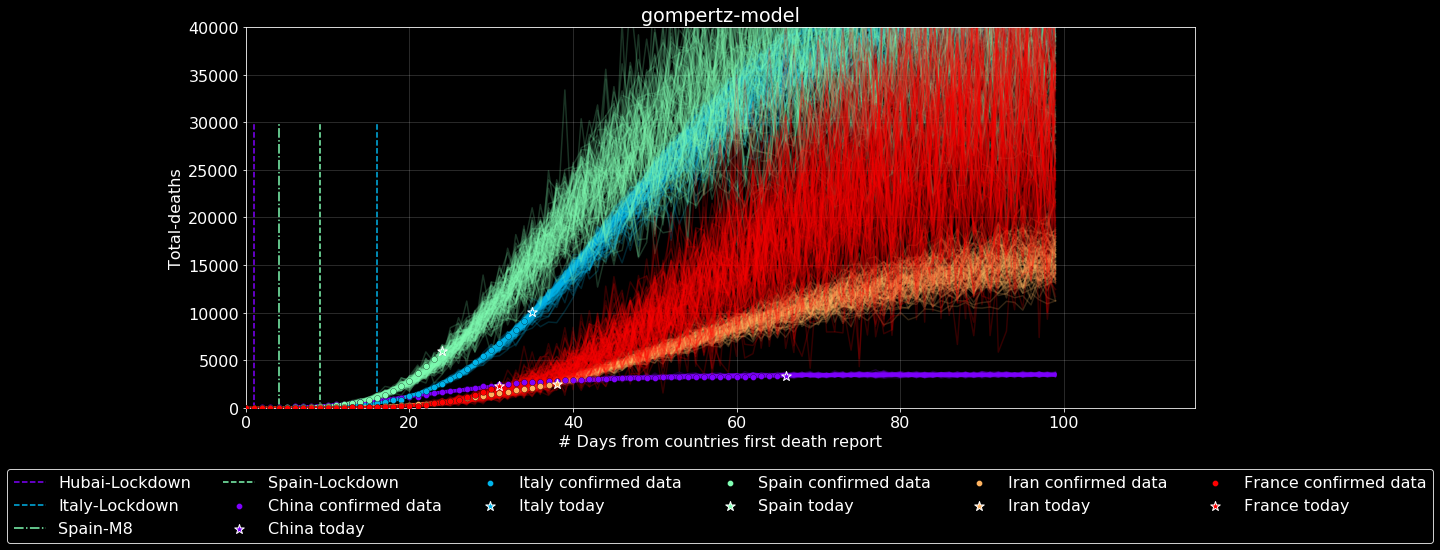

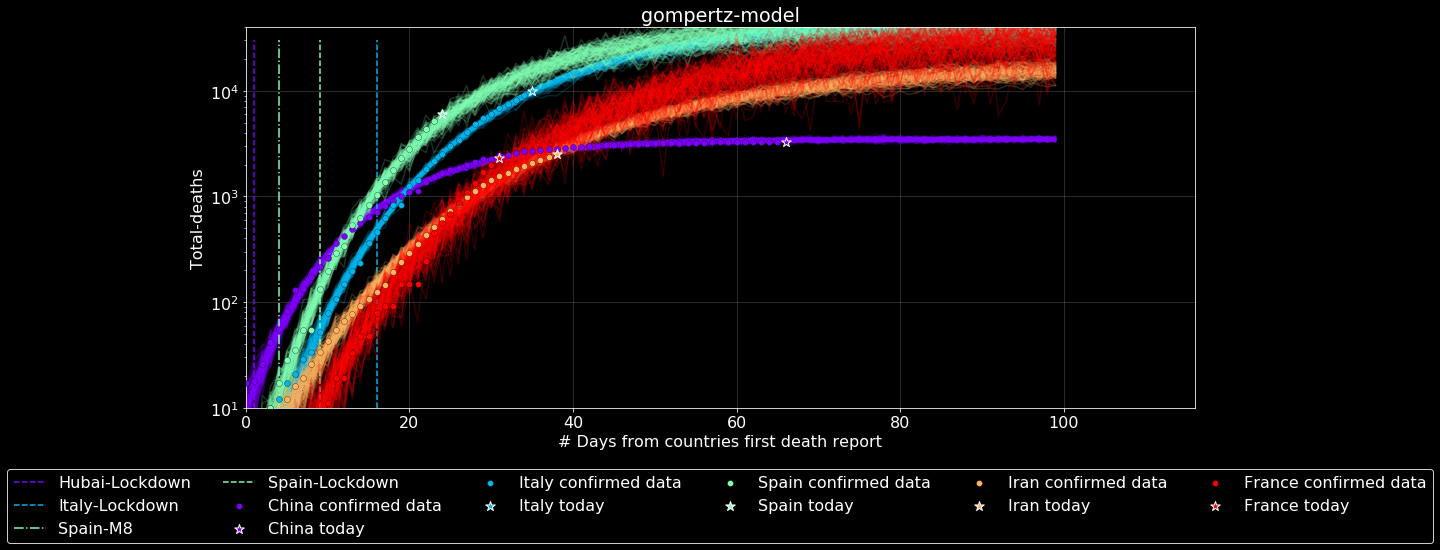

<Figure size 864x432 with 0 Axes>

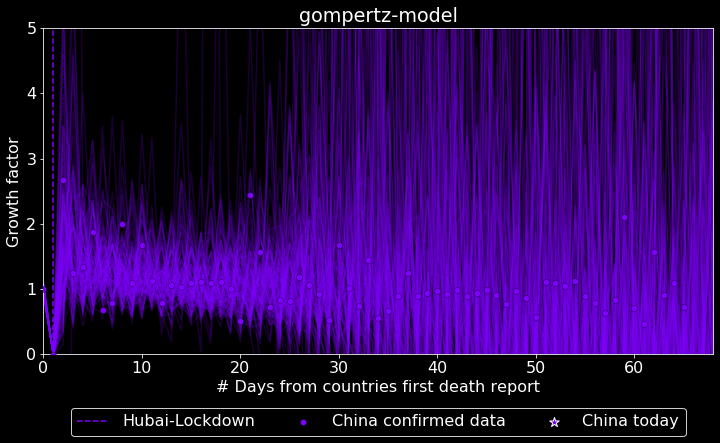

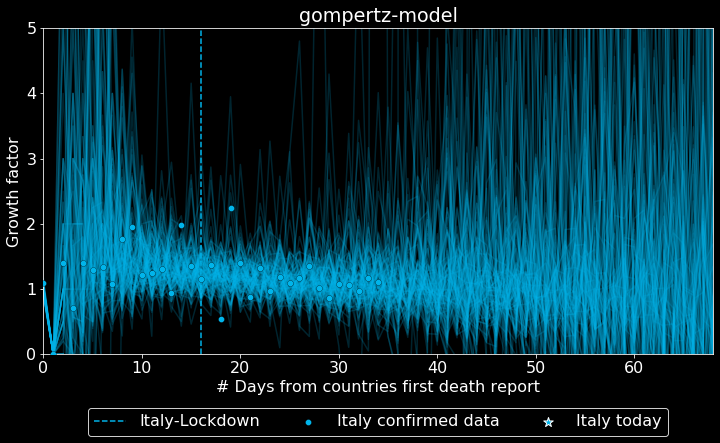

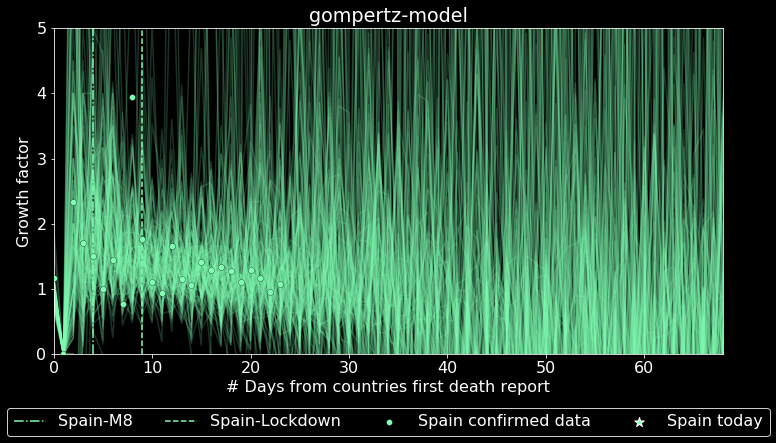

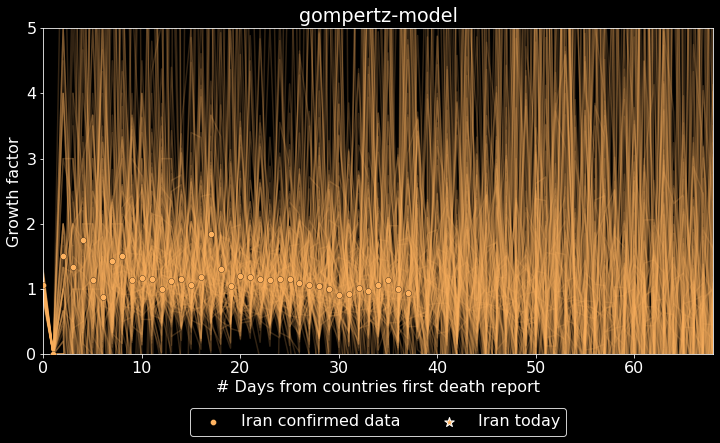

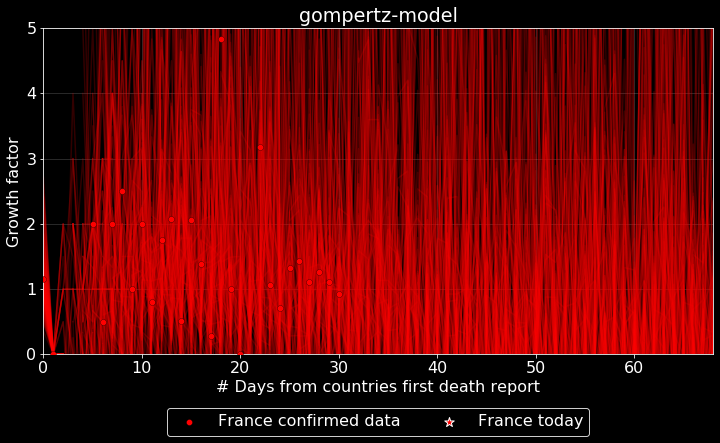

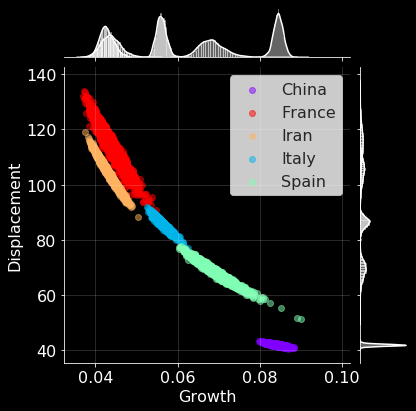

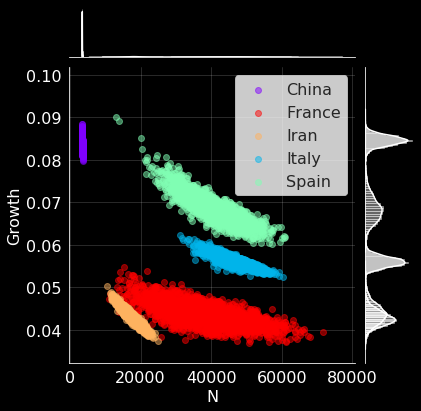

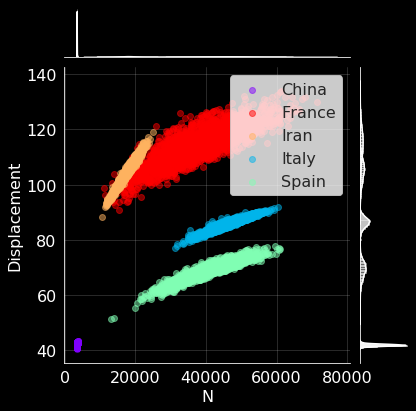

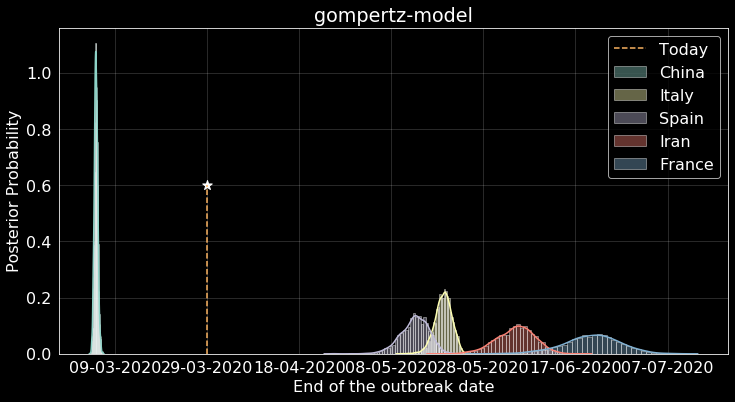

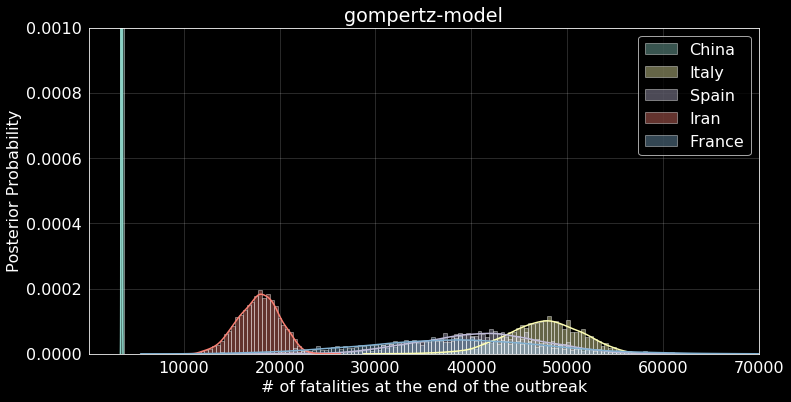

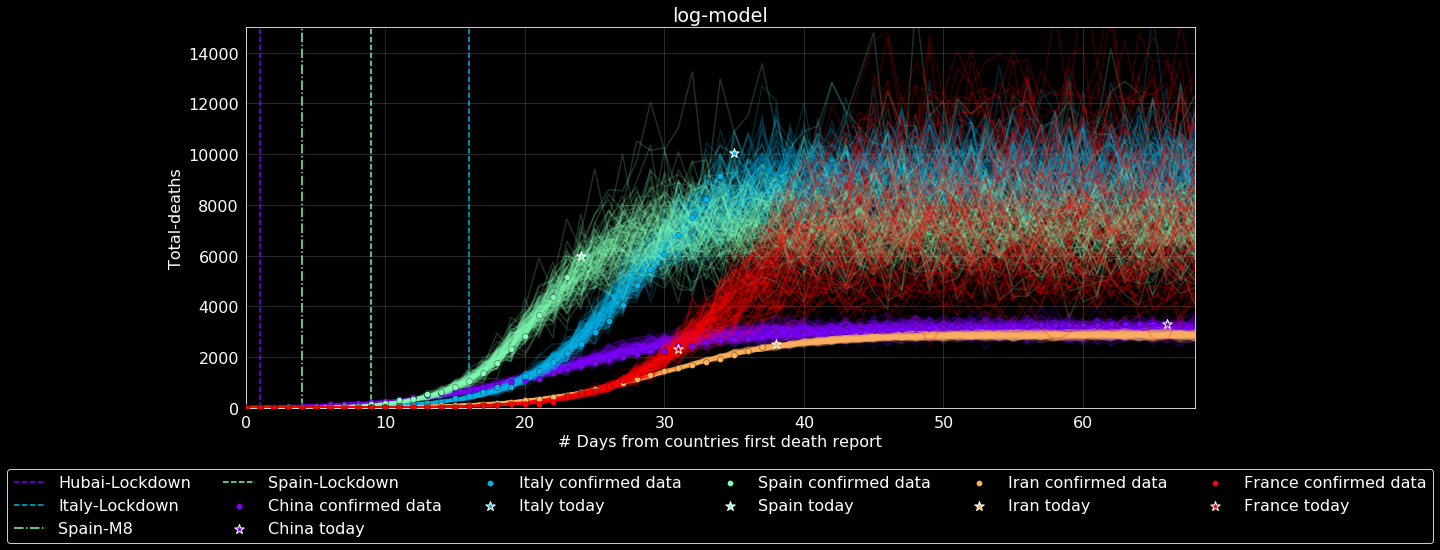

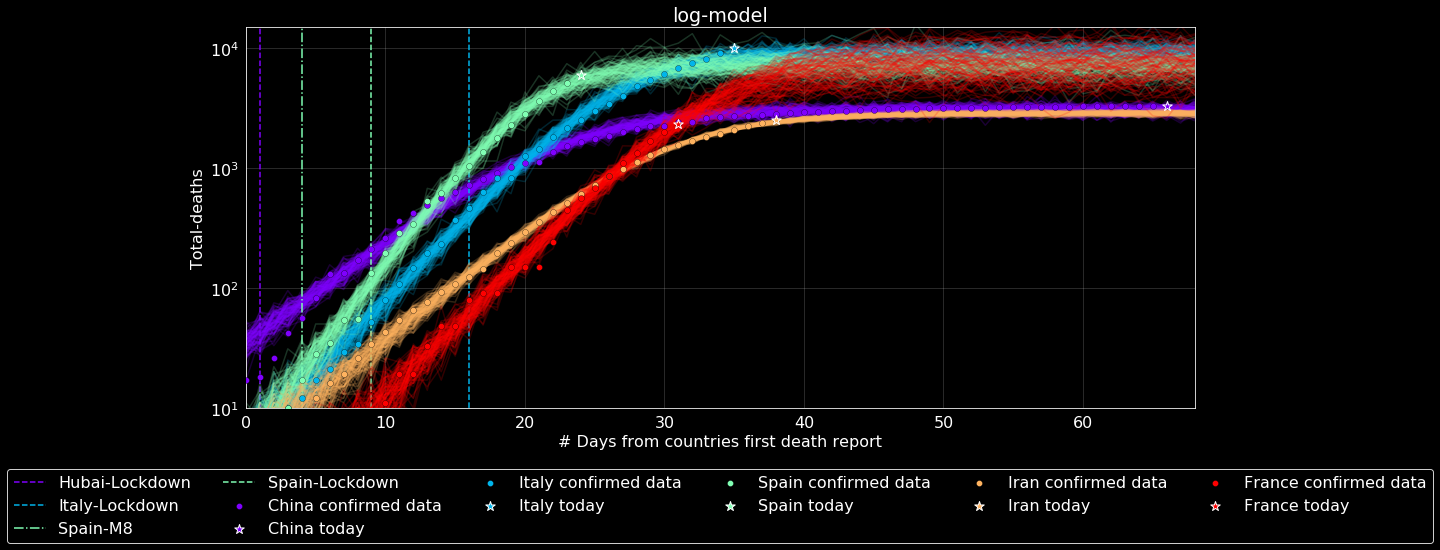

<Figure size 864x432 with 0 Axes>

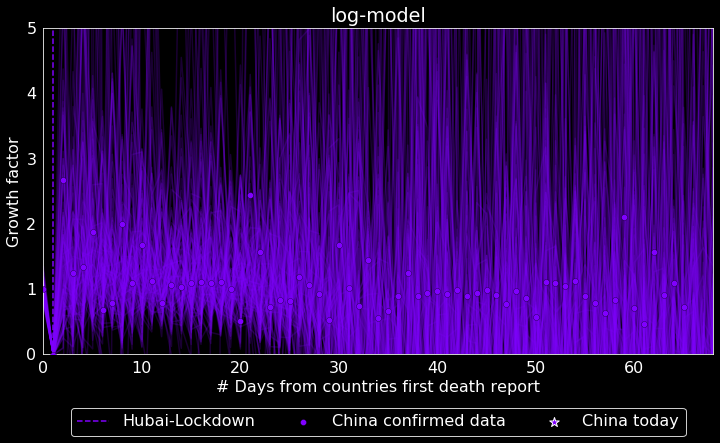

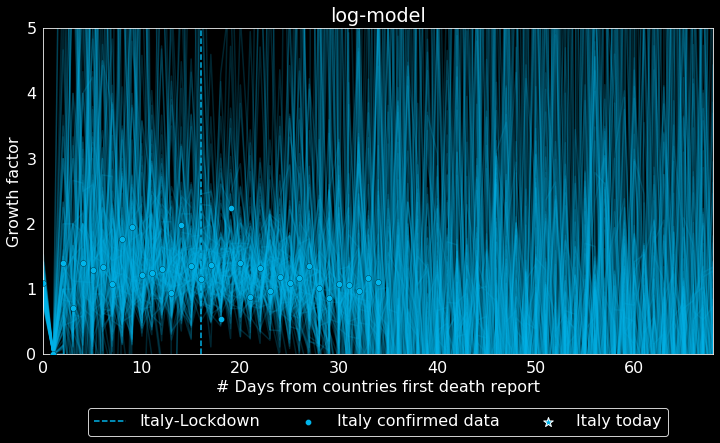

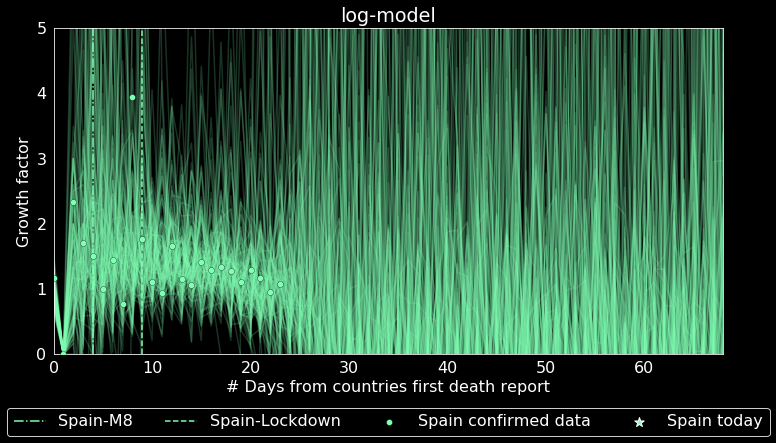

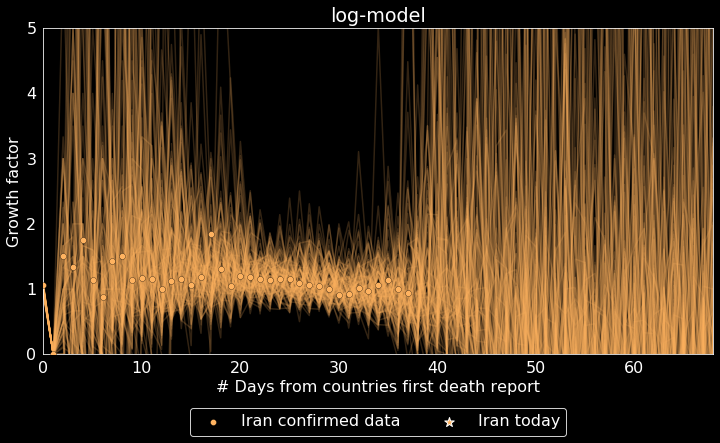

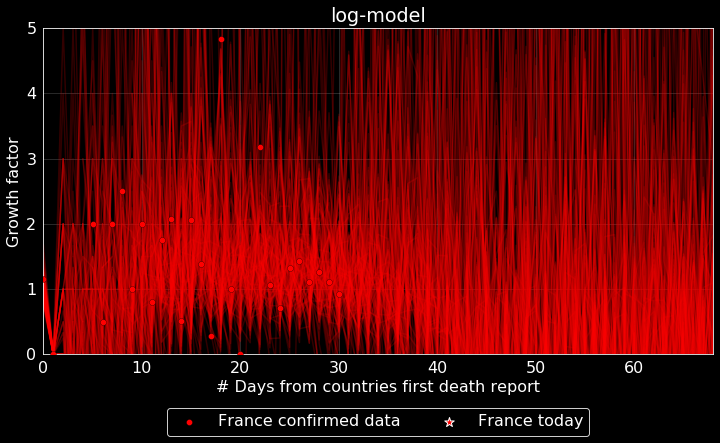

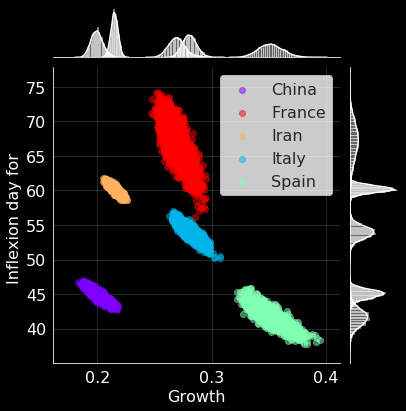

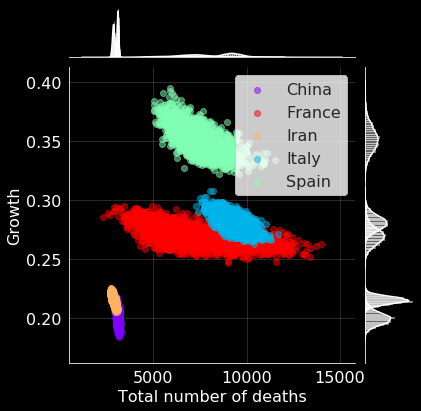

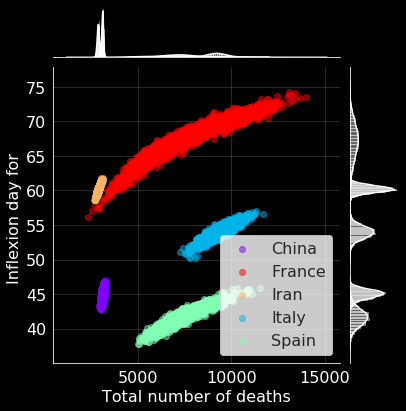

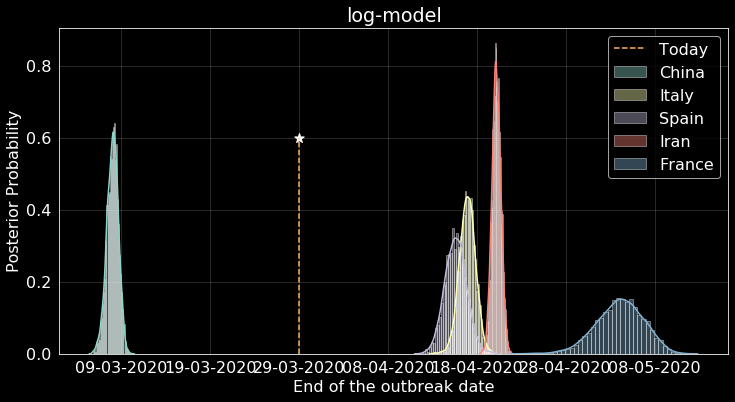

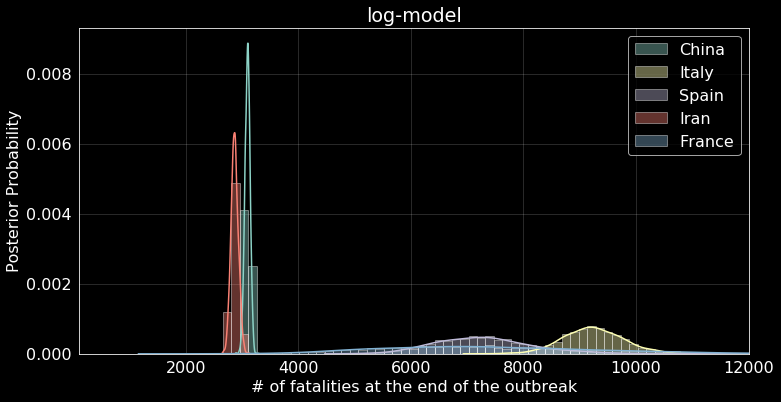

In [6]:
for method in ['gompertz-model', 'log-model']:
    ############################################ 

        #hide_input
    if method == 'log-model':
        clabel = {'c1':'Growth','c2':'Inflexion day for ','c3':'Total number of deaths'}

    if method == 'gompertz-model':
        clabel = {'c1':'Growth','c2':'Displacement','c3':'N'}
    
    bay_summary = pm.summary(traces[method])
    bay_summary = bay_summary.drop(list(bay_summary.index[bay_summary.index.str.contains('grp')]))
    bay_summary = bay_summary.drop(list(bay_summary.index[bay_summary.index.str.contains('sigma')]))
    
    for key, value in clabel.items():
        bay_summary.index = bay_summary.index.str.replace(key, value)

    for i, country in enumerate(countries):
        bay_summary.index = bay_summary.index.str.replace('['+str(i)+']',country)
    bay_summary = bay_summary.T.drop('r_hat').T

    html_content = '<h3>Results summary: '+str(data['Spain'+'-date'][-1])+'</h3>' + bay_summary.to_html().replace('\n', '')
    html_file = open("../tables/bay_summary"+method+".html", "wt")
    html_file.write(html_content)
    html_file.close()

    ############################################     


    GrowthR = {}
    GrowthR['data'] = data
    GrowthR['post_pred'] = post_preds[method]
    GrowthR['countries'] = countries
    GrowthR['ylabel'] = 'Growth factor'
    GrowthR['flag_res'] = True
    GrowthR['xlim'] = [0,data['China'+'-day'][-1] + 2]
    GrowthR['ylim'] = [0,5]
    GrowthR['log_flag'] = False
    GrowthR['figsize'] = (12, 6)
    GrowthR['trace'] = traces[method]
    GrowthR['method'] = method
    
    Sigmoid = {}
    Sigmoid['data'] = data
    Sigmoid['post_pred'] = post_preds[method]
    Sigmoid['countries'] = countries
    Sigmoid['ylabel'] = 'Total-deaths'
    Sigmoid['flag_res'] = False
    if method == 'log-model':
        Sigmoid['xlim'] = [0,data['China'+'-day'][-1] + 2]
        Sigmoid['ylim'] = [0,15000]
    if method == 'gompertz-model':
        Sigmoid['xlim'] = [0,data['China'+'-day'][-1] + 50]
        Sigmoid['ylim'] = [0,40000]
    Sigmoid['log_flag'] = False
    Sigmoid['figsize'] = (17, 7)
    Sigmoid['trace'] = traces[method]
    Sigmoid['method'] = method

    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 14}

    plt.style.use('dark_background')

    plot_results(Sigmoid)
    Sigmoid['ylim'] = [10,15000]
    if method == 'gompertz-model':
        Sigmoid['ylim'] = [10,40000]        
    Sigmoid['log_flag'] = True
    
    plot_results(Sigmoid)
    plot_results(GrowthR)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(countries)))
    colors_dic = {}                        
    for i, cn in enumerate(countries):
        colors_dic[cn] = colors[i]
    for k, cn in enumerate([['c1','c2'],['c3','c1'],['c3','c2']]):
        dfs = []
        for i, country in enumerate(countries):
            A = 1
            if cn[1] == 'c2':
                A = 2
            df = pd.DataFrame(np.append(traces[method][cn[0]][:, i],A*traces[method][cn[1]][:, i]).reshape(2,-1).T, columns=[clabel[cn[0]],clabel[cn[1]]])
            df['country'] = country
            dfs += [df]
        df=pd.concat(dfs)
        multivariateGrid(clabel[cn[0]],clabel[cn[1]], 'country', df=df, k_is_color = colors_dic) 

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12,6))

    for i, country in enumerate(countries):
        ax = sns.distplot(traces[method]['c2'][:,i]*2-data[country+'-day'][-1], label = country)

    plt.plot([0,0],[0,0.6],'--', label = "Today")
    plt.scatter(0,0.6, color='white', marker = '*', s = 100)
    plt.legend()    
    date_list = [(datetime.datetime.today() + datetime.timedelta(days=int(x))).strftime("%d-%m-%Y") for x in ax.get_xticks()]
    ax.set_xticklabels(date_list)

    plt.xlabel('End of the outbreak date')
    plt.ylabel('Posterior Probability')
    plt.title(method)
    lgd = plt.legend()
    plt.savefig('../images/'+'daystoend'+method+'.png', dpi=90, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.grid(alpha = 0.2)


    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12,6))

    for i, country in enumerate(countries):
        if method == 'log-model':   
            sns.distplot(traces[method]['c3'][:,i], label = country, bins = np.linspace(100,15000,100))
        else:
            sns.distplot(traces[method]['c3'][:,i], label = country, bins = np.linspace(100,80000,200))
        
    plt.xlabel('# of fatalities at the end of the outbreak')
    plt.ylabel('Posterior Probability')
    plt.title(method)
    lgd = plt.legend()
    plt.xlim([100,12000])
    if method == 'gompertz-model':               
        plt.xlim([100,70000])
        plt.ylim([0,0.001])
    plt.savefig('../images/'+'fatalities'+method+'.png', dpi=90, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.grid(alpha = 0.2)
    
    
    html_content = '<h3>The Bayes Factor (log-model)/(gompertz-model): '+str(np.round(np.exp(marginal_likelihood['log-model']-marginal_likelihood['gompertz-model']),2))+'</h3>' 
    html_file = open("../tables/last_bayes_factor.html", "wt")
    html_file.write(html_content)
    html_file.close()

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

KeyError: 'F-death'

<Figure size 1224x504 with 0 Axes>